# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [3]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [77]:
# Import essential libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
import shutil
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight

Load the dataset.

In [5]:
# Load and unzip the dataset
# shutil.rmtree('data')
if not os.path.exists("data") or len(os.listdir("data")) == 0:
    print("Unzipping dataset...")
    !unzip -q data.zip
    print("Unzipping completed...")
else:
    print("'data/' directory already contains files. Skipping unzip.")

'data/' directory already contains files. Skipping unzip.


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [6]:
# Create a function to load the raw images

def load_raw_images(data_dir):
  x=[]
  y=[]
  label_names=sorted(os.listdir(data_dir))
  for label in label_names:
    label_folder=os.path.join(data_dir, label)
    if not os.path.isdir(label_folder):
      continue
    for filename in os.listdir(label_folder):
      img_path=os.path.join(label_folder, filename)
      try:
        img = Image.open(img_path).convert('RGB')
        x.append(img)
        y.append(label)
      except Exception as e:
        continue
  return x, y, label_names

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [7]:
# Get the images and their labels
data_dir = 'data'
X_raw, y_raw, label_names = load_raw_images(data_dir)

print(f'Number of images: {len(X_raw)}')
print(f'Number of labels: {len(label_names)}')
print(f'Label names: {label_names}')

Number of images: 7625
Number of labels: 7
Label names: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


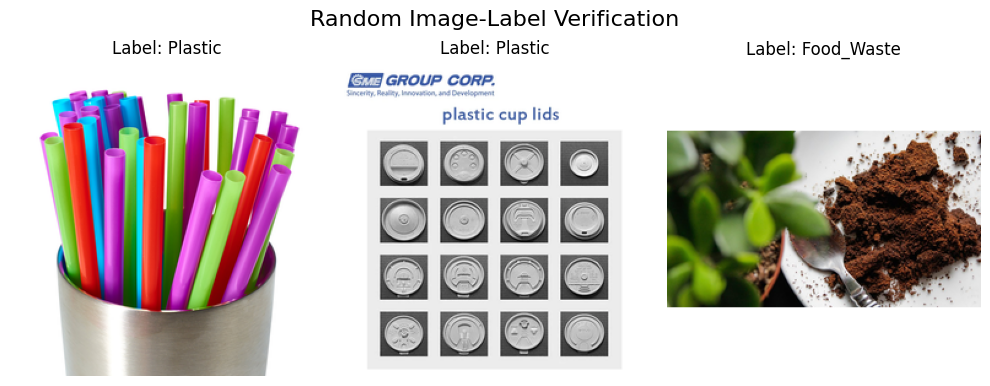

In [8]:
# Random image label verification for 3 images
indices = random.sample(range(len(X_raw)), 3)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(indices):
    plt.subplot(1, 3, i + 1)
    plt.imshow(X_raw[idx])
    plt.title(f"Label: {y_raw[idx]}")
    plt.axis("off")
plt.suptitle("Random Image-Label Verification", fontsize=16)
plt.tight_layout()
plt.show()

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

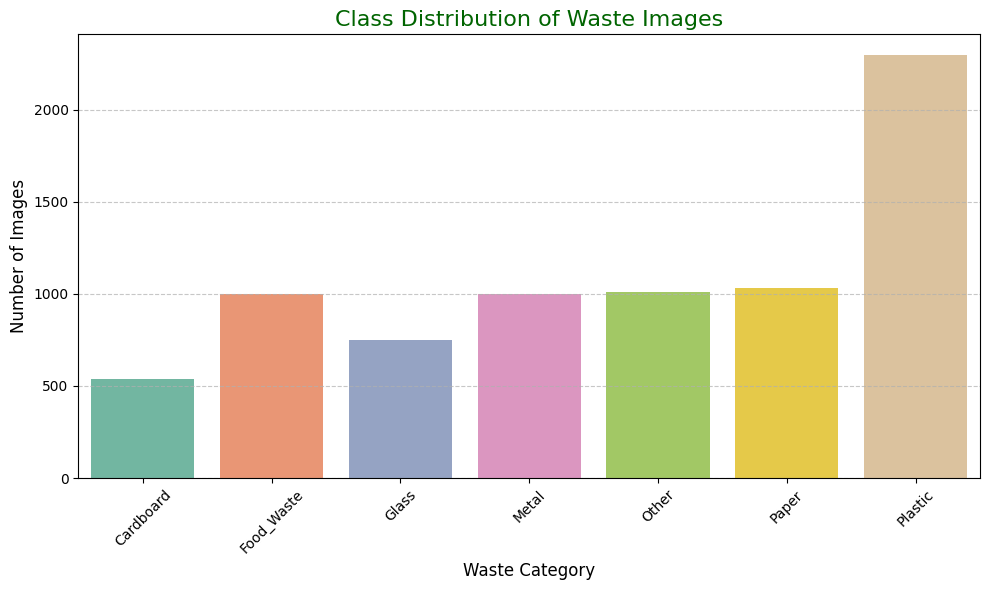

In [9]:
# Visualise Data Distribution
df = pd.DataFrame({'Label': y_raw})
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Label', hue='Label', palette='Set2')

plt.title("Class Distribution of Waste Images", fontsize=16, color='darkgreen')
plt.xlabel("Waste Category", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Observation:**
  

*   Imbalance between categories
*   Plastic has highest distribution



#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [10]:
# Visualise Sample Images (across different labels)
def visualize_images_by_label(label_type, num_images=6):
    target_indices = [i for i, label in enumerate(y_raw) if label == label_type]
    for i in range(num_images):
        plt.subplot(2,3, i+1)
        plt.imshow(X_raw[target_indices[i]])
        plt.axis("off")
    plt.suptitle(f'Images of {label_type}', fontsize=16, color='darkblue')
    plt.tight_layout()
    plt.show()

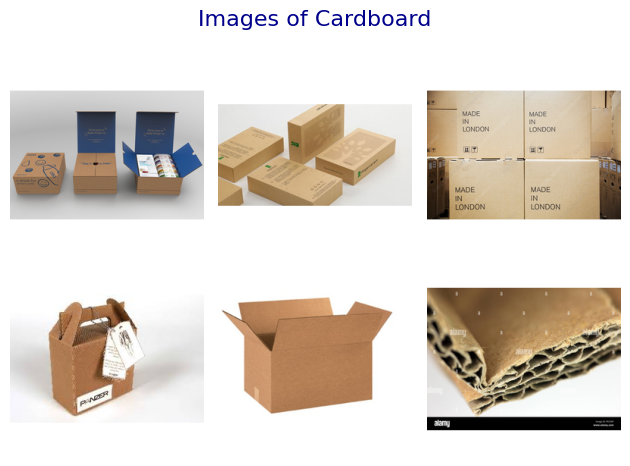

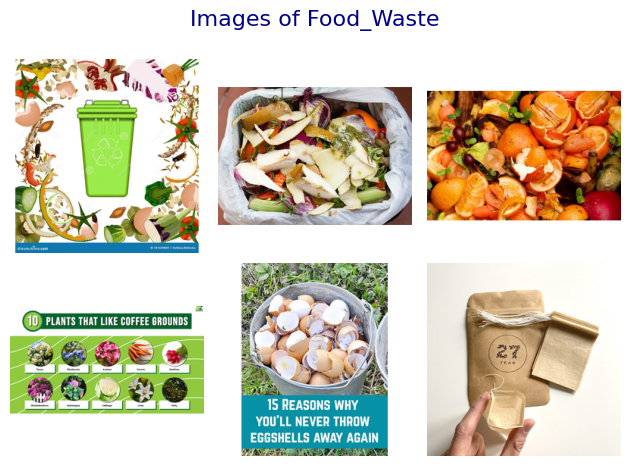

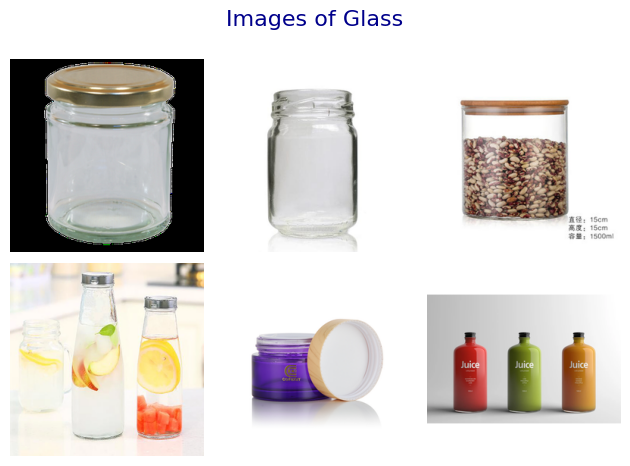

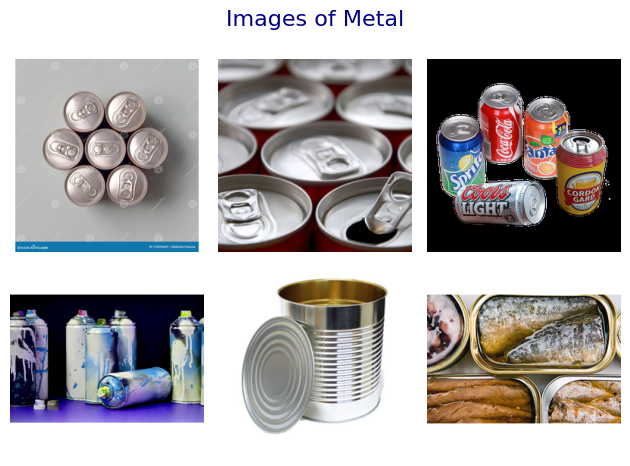

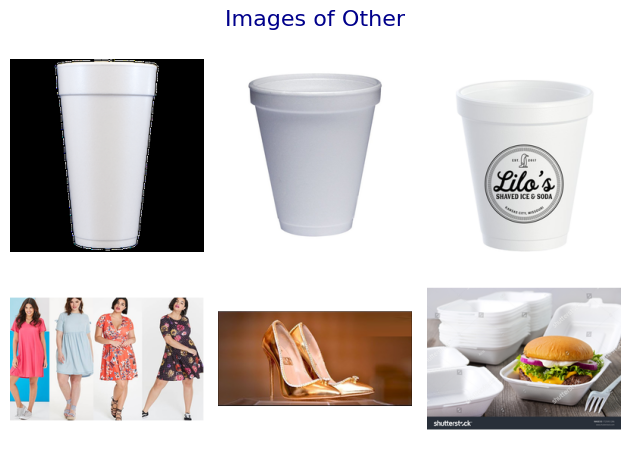

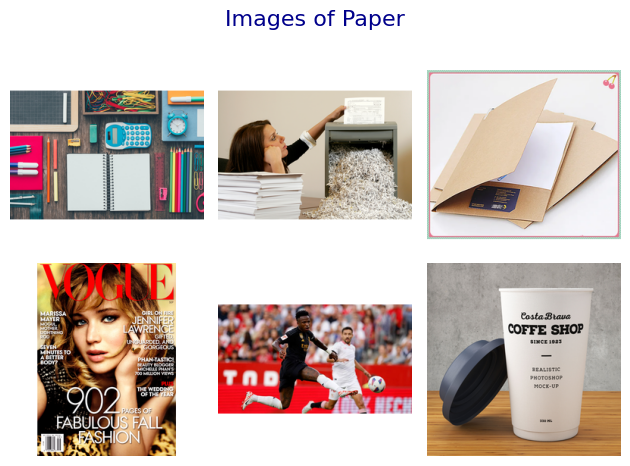

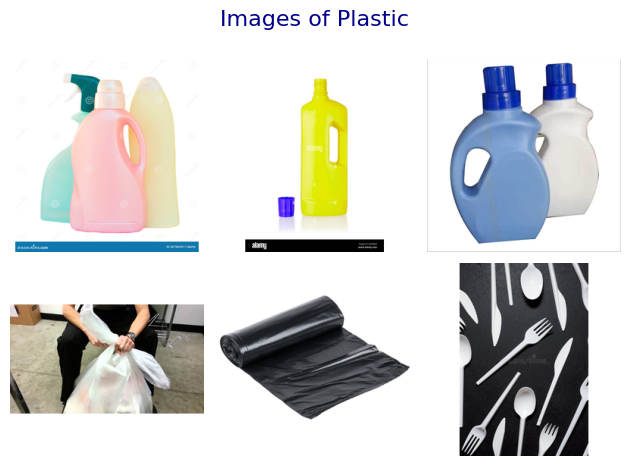

In [11]:
# visualize some 6 images from each label
for i in label_names:
    visualize_images_by_label(i)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [12]:
# Find the smallest and largest image dimensions from the data set
min_width = float('inf')
min_height = float('inf')
max_width = 0
max_height = 0

for img in X_raw:
    width, height = img.size
    min_width = min(min_width, width)
    min_height = min(min_height, height)
    max_width = max(max_width, width)
    max_height = max(max_height, height)

print(f"Smallest dimensions: {min_width}x{min_height}")
print(f"Largest dimensions: {max_width}x{max_height}")

Smallest dimensions: 256x256
Largest dimensions: 256x256


In [13]:
# Resize the image dimensions
def resize_and_normilize(X_raw, size=(256, 256)):
    resized=[]
    for img in X_raw:
        img_resize=img.resize(size)
        resized.append(np.array(img_resize) / 255.0)
    return np.array(resized)

In [14]:
X_resized=resize_and_normilize(X_raw, size=(128, 128))
y_array=np.array(y_raw)

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [15]:
# Encode the labels suitably
le = LabelEncoder()
y_int=le.fit_transform(y_raw)

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [16]:
# Assign specified parts of the dataset to train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train_int, y_val_int = train_test_split(
    X_resized, y_int, test_size=0.3, stratify=y_int, random_state=42
)

# One-hot encode after split
y_train = to_categorical(y_train_int, num_classes=7)
y_val = to_categorical(y_val_int, num_classes=7)

In [17]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {y_train.shape}")

print(f"X_val shape: {X_val.shape}")
print(f"Y_val shape: {y_val.shape}")

X_train shape: (5337, 128, 128, 3)
Y_train shape: (5337, 7)
X_val shape: (2288, 128, 128, 3)
Y_val shape: (2288, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [70]:
# Build and compile the model
model=Sequential()
model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 64)             │             

 Total params: 8,526,407 (32.53 MB)

 Trainable params: 8,525,063 (32.52 MB)

 Non-trainable params: 1,344 (5.25 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [71]:
# Training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=30,
    verbose=1,
    shuffle=True,
    initial_epoch=0,
    callbacks=[early_stop]
)

Epoch 1/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.1671 - loss: 3.8401 - val_accuracy: 0.1324 - val_loss: 6.0372
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2301 - loss: 3.4747 - val_accuracy: 0.1342 - val_loss: 6.5555
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2542 - loss: 3.2986 - val_accuracy: 0.1324 - val_loss: 6.9275
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2620 - loss: 3.2235 - val_accuracy: 0.1923 - val_loss: 5.0981
Epoch 5/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3087 - loss: 3.1006 - val_accuracy: 0.2365 - val_loss: 4.8787
Epoch 6/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3216 - loss: 3.0091 - val_accuracy: 0.2675 - val_loss: 3.5134
Epoch 7/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3271 - loss: 2.9386 - val_accuracy: 0.3160 - val_loss: 3.2288
Epoch 8/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3222 - loss: 2.9205 - val_acc

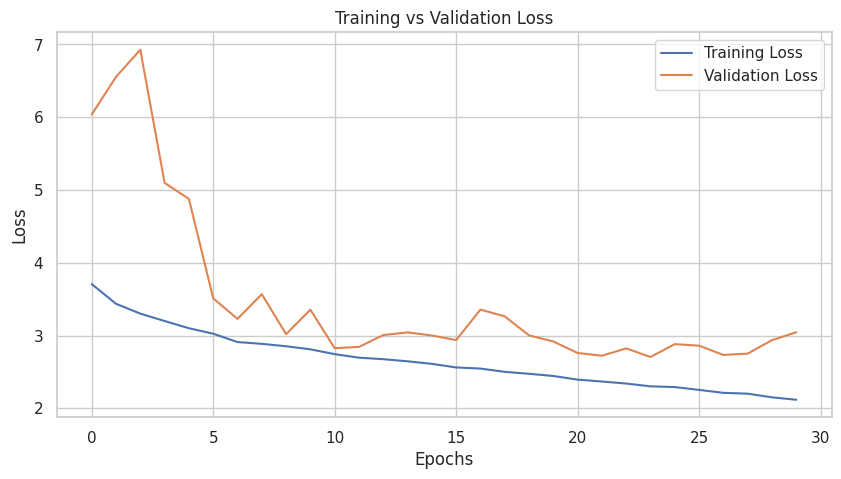

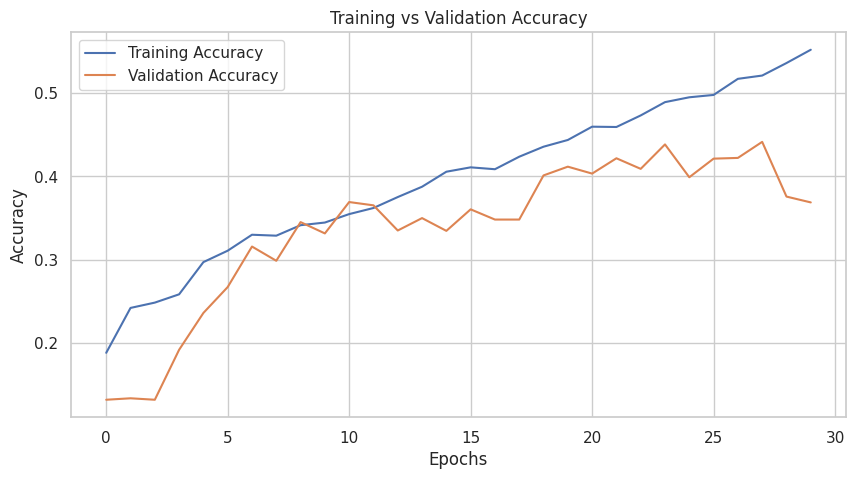

In [72]:

# Enable Seaborn styling
sns.set(style="whitegrid")

# Convert history.history to a DataFrame
import pandas as pd
history_df = pd.DataFrame(history.history)

# Add epoch index
history_df['epoch'] = history.epoch

# Plot loss
plt.figure(figsize=(10, 5))
sns.lineplot(x='epoch', y='loss', data=history_df, label='Training Loss')
sns.lineplot(x='epoch', y='val_loss', data=history_df, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

if 'accuracy' in history_df.columns:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x='epoch', y='accuracy', data=history_df, label='Training Accuracy')
    sns.lineplot(x='epoch', y='val_accuracy', data=history_df, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


**Observation:**
 * Evidence of Overfitting After Epoch 24
 * The training curve shows a smooth learning progression however validation accuracy is not good

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [73]:
# Evaluate on the test set; display suitable metrics
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4519 - loss: 2.7428
Test Accuracy: 0.4384
Test Loss: 2.7062


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


<Figure size 1000x800 with 0 Axes>

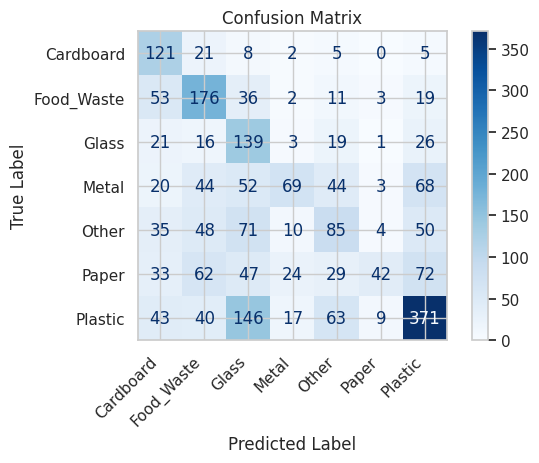

In [74]:
y_pred_probs = model.predict(X_val)
y_pred_int = np.argmax(y_pred_probs, axis=1)

y_val_int_actual = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_val_int_actual, y_pred_int)

class_labels = le.classes_


plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [78]:
print(classification_report(y_val_int_actual, y_pred_int, target_names=class_labels))

              precision    recall  f1-score   support

   Cardboard       0.37      0.75      0.50       162
  Food_Waste       0.43      0.59      0.50       300
       Glass       0.28      0.62      0.38       225
       Metal       0.54      0.23      0.32       300
       Other       0.33      0.28      0.30       303
       Paper       0.68      0.14      0.23       309
     Plastic       0.61      0.54      0.57       689

    accuracy                           0.44      2288
   macro avg       0.46      0.45      0.40      2288
weighted avg       0.50      0.44      0.42      2288



## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [83]:
# Define augmentation steps to augment images

train_datagen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator()

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [84]:
# Create a function to augment the images
def get_augmented_images(X, y, batch_size=32, is_val=False):
    if is_val:
        return val_datagen.flow(X, y, batch_size=batch_size, shuffle=False)
    return train_datagen.flow(X, y, batch_size=batch_size, shuffle=True)

In [85]:
# Create the augmented training dataset
train_generator = get_augmented_images(X_train, y_train, batch_size=32)
val_generator = get_augmented_images(X_val, y_val, batch_size=32, is_val=True)

##### **4.1.2**

Train the model on the new augmented dataset.

In [86]:
# Train the model using augmented images
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history_aug = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    initial_epoch=0,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.3756 - loss: 2.5290 - val_accuracy: 0.4266 - val_loss: 2.5587
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.3999 - loss: 2.4517 - val_accuracy: 0.4685 - val_loss: 2.3704
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.4026 - loss: 2.4364 - val_accuracy: 0.4602 - val_loss: 2.3935
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.4137 - loss: 2.4029 - val_accuracy: 0.4611 - val_loss: 2.4133
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.4372 - loss: 2.3630 - val_accuracy: 0.4537 - val_loss: 2.4657
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.4465 - loss: 2.2964 - val_accuracy: 0.4554 - val_loss: 2.4129
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.4428 - loss: 2.3093 - val_accuracy: 0.4454 - val_loss: 2.3212
Epoch 8/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.4395 - loss: 2

In [89]:
# Metrics after augmentation
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4800 - loss: 2.2393
Test Accuracy: 0.4624
Test Loss: 2.2471


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<Figure size 1000x800 with 0 Axes>

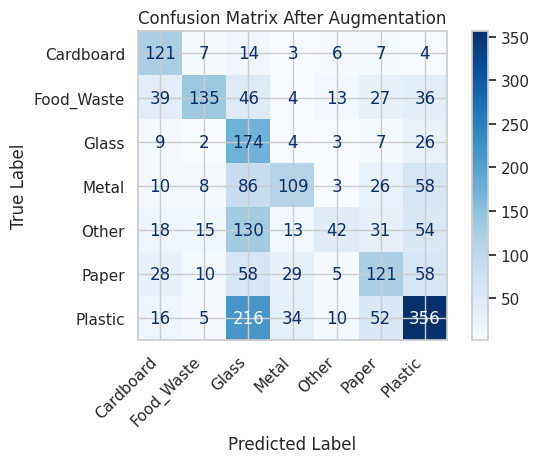

In [90]:
y_pred_probs = model.predict(X_val)
y_pred_int = np.argmax(y_pred_probs, axis=1)

y_val_int_actual = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_val_int_actual, y_pred_int)

class_labels = le.classes_


plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix After Augmentation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [91]:
print(classification_report(y_val_int_actual, y_pred_int, target_names=class_labels))

              precision    recall  f1-score   support

   Cardboard       0.50      0.75      0.60       162
  Food_Waste       0.74      0.45      0.56       300
       Glass       0.24      0.77      0.37       225
       Metal       0.56      0.36      0.44       300
       Other       0.51      0.14      0.22       303
       Paper       0.45      0.39      0.42       309
     Plastic       0.60      0.52      0.56       689

    accuracy                           0.46      2288
   macro avg       0.51      0.48      0.45      2288
weighted avg       0.54      0.46      0.46      2288



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

# **Key Findings about the the data:**



*   The dataset contains labeled colored images (size 256×256 pixels) across seven waste categories. The visual distribution indicates an imbalance across classes, which has key implications for model performance.


*   Plastic has the highest number of images, with over 2200 samples, making it the dominant class in the dataset
*   Cardboard has the fewest images, with just over 500 samples, indicating a significant class imbalance.


*   Other categories such as Food Waste, Metal, Other, and Paper have roughly similar representation, each around 1000–1050 images.
*   Glass has slightly fewer images (approx 750) compared to others in the mid-range

*  Paper class may be difficult to classify accurately because images often contain multiple waste materials (e.g., glass or plastic mixed with paper)
*  This inter-class visual overlap can lead to confusion for the model, especially in borderline or mixed scenarios







# **Model Performance Report: CNN for Waste Classification**


# 1.  Initial Training (Baseline Model)
     
 *   The model was trained without Dropout or Batch Normalization
 *   This led to overfitting, as evident from a significant gap between training and validation accuracy.


# 2.   Architectural Improvements

  *   Added Dropout layers to reduce overfitting
  *  Integrated Batch Normalization to stabilize learning.
  *   Applied L2 Kernel Regularization to penalize large weights
  *   Tuned Adam optimizer learning rate to 0.0001 for better convergence
  *   Used EarlyStopping to avoid unnecessary training and restore best weights
  * Test Accuracy improved to 0.4384

  * Test Loss reduced to 2.7

# 3. After Augmentation
   * Applied data augmentation to increase generalization.

   * Used techniques like rotation, zoom, etc.

   * Test Accuracy improved to 0.4624

   * Test Loss reduced to 2.24

# 4. Confusion Matrix Comparison
* Before Augmentation:
  * Frequent confusion between:

    * Paper vs Plastic

    * Glass vs Metal

    * Cardboard vs Other

 Some classes like Plastic are better predicted due to class imbalance.


* After Augmentation:
  * Clear improvements in:

    * Glass, Metal, and Paper classification accuracy

    * Reduced confusion between Paper and Other categories

    * Overall better class balance in predictions.

# 5. Key Takeaways
* Data augmentation and regularization significantly improved model generalization.

* Plastic remained the most confidently predicted class due to high sample size.

* Misclassification still exists between visually similar waste categories, such as Paper & Plastic.

* By applying transfer learning using pre-trained CNNs like ResNet or VGGNet, we can boost model performance as these models are already trained on large datasets
